### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib 
#import swifter
from scipy import stats
import pandahouse
%matplotlib inline

### Подключение к БД

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

### Выгрузка данных

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

### Анализ теста между группами 0 и 3

#### Подсчет общего CTR в контрольной группе 0

In [4]:
CTRcontrol_0 = df.query('exp_group==0')['likes'].sum() / df.query('exp_group==0')['views'].sum() 
CTRcontrol_0

0.20823612262916305

#### Подсчет поюзерной метрики c 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 по контрольной группе 0

In [5]:
df['linearized_likes'] = 0
df.loc[df['exp_group'] == 0, 'linearized_likes'] = df['likes'] - CTRcontrol_0 * df['views']
df.loc[df['exp_group'] == 3, 'linearized_likes'] = df['likes'] - CTRcontrol_0 * df['views']

#### Визуализируем обе метрики

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

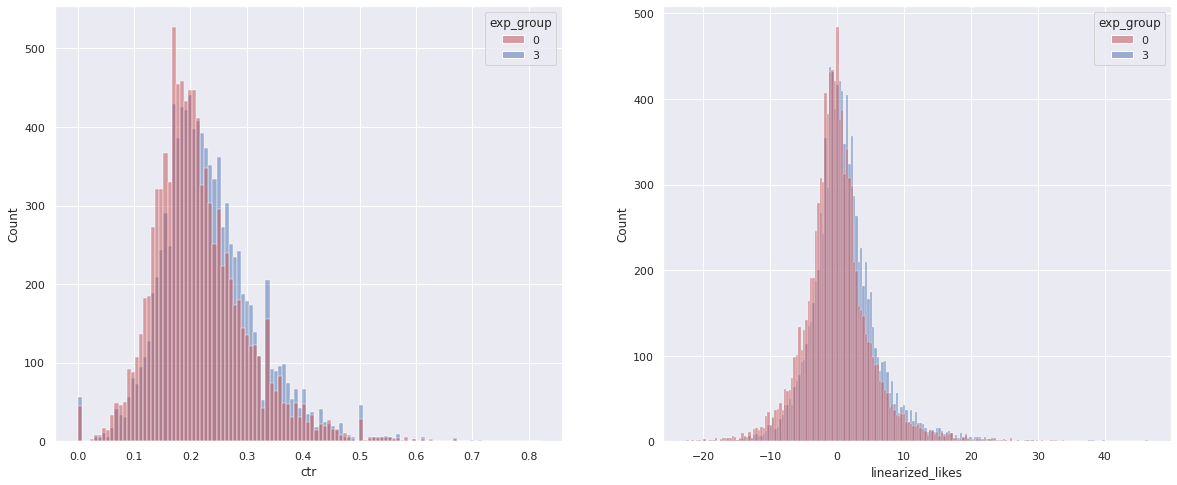

In [6]:
sns.set(rc={'figure.figsize':(20,8)})

sns.histplot(data = df.query('exp_group in [0, 3]'), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=plt.subplot(1, 2, 1))
sns.histplot(data = df.query('exp_group in [0, 3]'), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=plt.subplot(1, 2, 2))

#### T-test на группах 0 и 3 по метрике линеаризованных лайков

In [7]:
stats.ttest_ind(df.query('exp_group==0')['linearized_likes'], 
                df.query('exp_group==3')['linearized_likes'], 
                equal_var = False)[1]

5.4914249479690016e-52

#### T-test на группах 0 и 3 по CTR

In [8]:
stats.ttest_ind(df.query('exp_group==0')['ctr'], 
                df.query('exp_group==3')['ctr'], 
                equal_var = False)[1]

1.055849414662529e-43

**Промежуточный вывод**  
p-value в T-test'e по метрике линеаризованных лайков стало меньше, чем p-value в T-test'e по CTR. (e-52 < e-43).

### Анализ теста между группами 1 и 2

#### Подсчет общего CTR в контрольной группе 1

In [9]:
CTRcontrol_1 = df.query('exp_group==1')['likes'].sum() / df.query('exp_group==1')['views'].sum() 
CTRcontrol_1

0.20802680490126244

#### Подсчет поюзерной метрики c 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 по контрольной группе 1

In [10]:
df.loc[df['exp_group'] == 1, 'linearized_likes'] = df['likes'] - CTRcontrol_1 * df['views']
df.loc[df['exp_group'] == 2, 'linearized_likes'] = df['likes'] - CTRcontrol_1 * df['views']

#### Визуализируем обе метрики

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

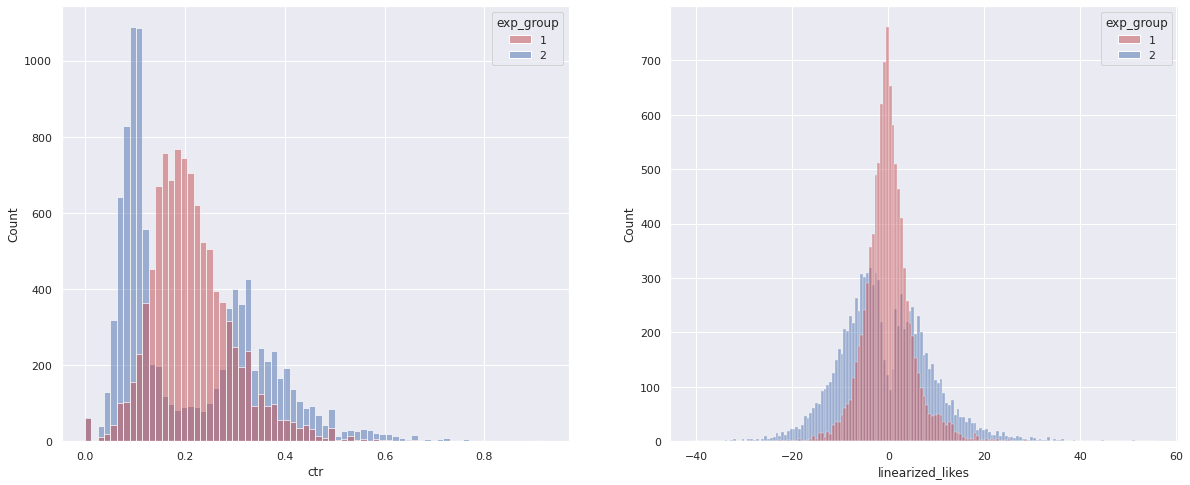

In [11]:
sns.set(rc={'figure.figsize':(20, 8)})

sns.histplot(data = df.query('exp_group in [1, 2]'), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=plt.subplot(1, 2, 1))
sns.histplot(data = df.query('exp_group in [1, 2]'), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              ax=plt.subplot(1, 2, 2))

#### T-test на группах 1 и 2 по метрике линеаризованных лайков

In [12]:
stats.ttest_ind(df.query('exp_group==1')['linearized_likes'], 
                df.query('exp_group==2')['linearized_likes'], 
                equal_var = False)[1]

9.439432187037712e-10

#### T-test на группах 1 и 2 по CTR

In [13]:
stats.ttest_ind(df.query('exp_group==1')['ctr'], 
                df.query('exp_group==2')['ctr'], 
                equal_var = False)[1]

0.4780623130874935

**Промежуточный вывод**  
p-value в T-test'e по метрике линеаризованных лайков стало меньше, чем p-value в T-test'e по CTR. (e-10 < 0.47)